# Flash Model for [R32][emim_TF2N]
### Gabriela Franco
### 03/10/21

In [1]:
# import functions
import idaes
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from idaes.core import FlowsheetBlock
import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus
# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)
# Import unit models from the model library
from idaes.generic_models.unit_models import Flash
# Import degrees of freedom tool
from idaes.core.util.model_statistics import degrees_of_freedom
# import HFC_IL mixture properties
from HFC32_emimTf2N_PR import configuration

## Run Parameter Estimation Function

**T = 298.15 K**

In [2]:
#run parameter estimation function

# T= 298.15 k
from binary_param2 import binary_params_peng
from HFC32_emimTf2N_PR import configuration
binary_params_peng('R32_emimTf2N.csv', configuration, 'R32', 'emimTf2N', "x_R32", "x_emimTf2N", 
    init_temp = 298.15, init_press = 250200, init_x_c1 = 0.218, init_x_c2 =0.782 ,
    init_kappa_2_1 = -0.20, init_kappa_1_2 = -0.058, eps = 0.1, scaling_fac = 1e-4)


2021-03-24 10:38:48 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-03-24 10:38:48 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-03-24 10:38:48 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-03-24 10:38:48 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-03-24 10:38:48 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-03-24 10:38:48 [INFO] idaes.init.fs.state_

2021-03-24 10:38:54 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-03-24 10:38:54 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-03-24 10:38:54 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-03-24 10:38:54 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-03-24 10:38:54 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-03-24 10:38:55 [INFO] idaes.init.fs.state_

## Create Flash Model

In [3]:
# Read data
data = pd.read_csv('R32_emimTf2N.csv')
data_283= data[0:7]
data_298 = data[7:15]
data_323 = data[15:23]
data_348 = data[23:31]
print(data_298)

    temperature  pressure  x_R32  x_emimTf2N
7        298.15      9600  0.010       0.990
8        298.15     99800  0.095       0.905
9        298.15    250200  0.218       0.782
10       298.15    399400  0.325       0.675
11       298.15    549400  0.417       0.583
12       298.15    699500  0.499       0.501
13       298.15    849500  0.570       0.430
14       298.15    999700  0.643       0.357


In [4]:
m = ConcreteModel()
m.fs = FlowsheetBlock(default={"dynamic": False})
m.fs.properties = GenericParameterBlock(default=configuration)
m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})
DOF_initial = degrees_of_freedom(m)
print('The initial DOF is {0}'.format(DOF_initial))

2021-03-24 10:38:58 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
The initial DOF is 7


**T=298.15 K**

In [5]:
def calc_outlet_xP(data,k21,k12,verbose=False):
    # create zeros arrays to be filled with x1 and P1
    R32_x = np.zeros((len(data)))
    P = np.zeros((len(data)))
    
    # model constraints
    m.fs.liq = Param(mutable=True,default=0.040)
    m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"] == m.fs.liq)

    for i in range(len(data)):
        m.fs.liq = data["x_emimTf2N"].iloc[i]
        m.fs.F101.inlet.flow_mol.fix(1) 
        m.fs.F101.inlet.temperature.fix(float(data["temperature"].iloc[i]))
        m.fs.F101.inlet.pressure.fix(float(data["pressure"].iloc[i]))
        m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(float(data["x_R32"].iloc[i])+0.1)
        m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(float(1-(data["x_R32"].iloc[i]+0.1)))
        m.fs.F101.vap_outlet.temperature.fix(float(data["temperature"].iloc[i]))
        m.fs.properties.PR_kappa['emimTf2N', 'R32'].fix(k21) # (-0.20093)
        m.fs.properties.PR_kappa['R32', 'emimTf2N'].fix(k12) # (-0.05619)

        if verbose:
            DOF_final = degrees_of_freedom(m)
            print("The final DOF is {0}".format(DOF_final))

        # solver
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
        solver = SolverFactory('ipopt')
        solver.options = {'tol': 1e-6}
        status = solver.solve(m, tee = False)
    #     m.fs.F101.report()
        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
            R32_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
            P[i] = value(m.fs.F101.vap_outlet.pressure[0])
        else:
            print('Infeasible.')
    return(R32_x,P)

In [6]:
R32_x,P= calc_outlet_xP(data_298,-0.20,-0.06, verbose=True)

The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0


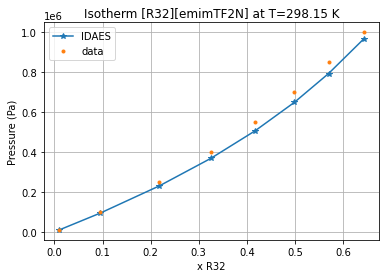

In [7]:
plt.plot(R32_x,P,"-*",label="IDAES")  
plt.plot(data_298["x_R32"],data_298["pressure"],".",label="data")  
plt.title('Isotherm [R32][emimTF2N] at T=298.15 K')
plt.ylabel('Pressure (Pa)')
plt.xlabel('x R32')
plt.grid(True)
plt.legend()
plt.show()

## Sensitivity Analysis

**T= 298.15K**

In [8]:
# Read data
data = pd.read_csv('R32_emimTf2N.csv')
data_283= data[0:7]
data_298 = data[7:15]
data_323 = data[15:23]
data_348 = data[23:31]
print(data_298)

    temperature  pressure  x_R32  x_emimTf2N
7        298.15      9600  0.010       0.990
8        298.15     99800  0.095       0.905
9        298.15    250200  0.218       0.782
10       298.15    399400  0.325       0.675
11       298.15    549400  0.417       0.583
12       298.15    699500  0.499       0.501
13       298.15    849500  0.570       0.430
14       298.15    999700  0.643       0.357


**Change kappa values manually and see behavior**

In [9]:
# plot function to see if it works - works when i store value, plot, store value 2, plot 2 etc
def plot_sens_analysis(data,kappa21,kappa12,T_label):
    x1,P1= calc_outlet_xP(data, kappa21[0],kappa12[0])
    plt.plot(x1,P1,"b+-",label="K21=-0.2, K12=-0.056")
    x2,P2= calc_outlet_xP(data,kappa21[0],kappa12[1])
    plt.plot(x2,P2,"g+",label="K21=-0.2, K12=-0.066")
    x3,P3= calc_outlet_xP(data,kappa21[0],kappa12[2])
    plt.plot(x3,P3,"m+",label="K21=-0.2, K12=-0.076")
    x4,P4= calc_outlet_xP(data,kappa21[0],kappa12[3])
    plt.plot(x4,P4,"c+",label="K21=-0.2, K12=-0.086")
    x5,P5= calc_outlet_xP(data,kappa21[1],kappa12[0])
    plt.plot(x5,P5,"b*",label="K21=-0.3, K12=-0.056")
    x6,P6= calc_outlet_xP(data,kappa21[1],kappa12[1])
    plt.plot(x6,P6,"g*",label="K21=-0.3, K12=-0.066")
    x7,P7= calc_outlet_xP(data,kappa21[1],kappa12[2])
    plt.plot(x7,P7,"m*",label="K21=-0.3, K12=-0.076")
    x8,P8= calc_outlet_xP(data,kappa21[1],kappa12[3])
    plt.plot(x8,P8,"c*",label="K21=-0.3, K12=-0.086")
    x9,P9= calc_outlet_xP(data,kappa21[2],kappa12[0])
    plt.plot(x9,P9,"b^",label="K21=-0.4, K12=-0.056")
    x10,P10= calc_outlet_xP(data,kappa21[2],kappa12[1])
    plt.plot(x10,P10,"g^",label="K21=-0.4, K12=-0.066")
    x11,P11= calc_outlet_xP(data,kappa21[2],kappa12[2])
    plt.plot(x11,P11,"m^",label="K21=-0.4, K12=-0.076")
    x12,P12= calc_outlet_xP(data,kappa21[2],kappa12[3])
    plt.plot(x12,P12,"c^",label="K21=-0.4, K12=-0.086")
    # plot data and configuration
    plt.plot(data["x_R32"],data["pressure"],"r.",label="data")  
    plt.title('Isotherm [R32][emimTF2N] at '+ T_label)
    plt.ylabel('Pressure (Pa)')
    plt.xlabel('x R32')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()

    'pyomo.core.base.param.SimpleParam'>) on block fs with a new Component
    (type=<class 'pyomo.core.base.param.SimpleParam'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.SimpleConstraint'>) on block fs with a new
    Component (type=<class
    'pyomo.core.base.constraint.AbstractSimpleConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.param.SimpleParam'>) on block fs with a new Component
    (type=<class 'pyomo.core.base.param.SimpleParam'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.SimpleConstraint'>) on block fs with a new
    Component (type=<class
    'pyomo.core.base.constraint.AbstractSimpleConstraint'>). This is usual

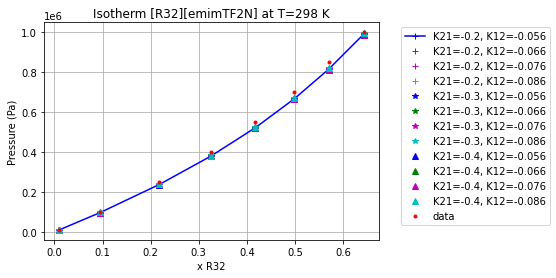

In [13]:
kappa21= np.array([-0.202,-0.20093,-0.199,-0.189])
kappa12= np.array([-0.0563,-0.05619,-0.0561,-0.055])
plot_sens_analysis(data_298,kappa21,kappa12, "T=298 K")

#### ^^^^ from this graph, the blue + sign looks like the best fit

## Plot all isotherms with Sensitivity Analysis Kappas

    'pyomo.core.base.param.SimpleParam'>) on block fs with a new Component
    (type=<class 'pyomo.core.base.param.SimpleParam'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.SimpleConstraint'>) on block fs with a new
    Component (type=<class
    'pyomo.core.base.constraint.AbstractSimpleConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The

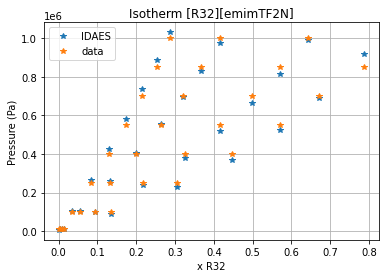

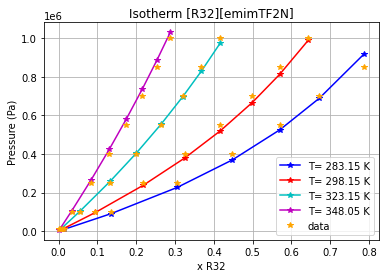

In [11]:
R32_x,P= calc_outlet_xP(data,-0.20093139701830656,-0.05619426266499131,verbose=True)

# plot with data straight out of the function

plt.plot(R32_x,P,"*",label="IDAES")  
plt.plot(data["x_R32"],data["pressure"],"*",label="data")  
plt.title('Isotherm [R32][emimTF2N]')
plt.ylabel('Pressure (Pa)')
plt.xlabel('x R32')
plt.grid(True)
plt.legend()
plt.show()

# plots with data - model as lines --- need to make this into a function that splits up the T's
plt.plot(R32_x[0:7],P[0:7],"b*-",label="T= 283.15 K")  
plt.plot(R32_x[7:15],P[7:15],"r*-",label="T= 298.15 K") 
plt.plot(R32_x[15:23],P[15:23],"c*-",label="T= 323.15 K") 
plt.plot(R32_x[23:],P[23:],"m*-",label="T= 348.05 K")
plt.plot(data["x_R32"],data["pressure"],"*",color='orange',label="data")  
plt.title('Isotherm [R32][emimTF2N]')
plt.ylabel('Pressure (Pa)')
plt.xlabel('x R32')
plt.grid(True)
plt.legend()
plt.show()